In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import os

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [3]:
from torchvision import datasets
Crop_name = r"D:\Image analysis folder\Cauliflower"
train_dataset = datasets.ImageFolder(r"D:\Image analysis folder\Cauliflower\Train", transform=train_transform)
test_dataset = datasets.ImageFolder(r"D:\Image analysis folder\Cauliflower\Test", transform=test_transform)


In [4]:
indices = list(range(len(train_dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

In [5]:
train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)

In [6]:
train_loader = DataLoader(train_subset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=20)
test_loader = DataLoader(test_dataset, batch_size=20)

In [10]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(device)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
import time
num_epochs = 20  # ✅ Define number of training epochs
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
epoch_times = []

for epoch in range(num_epochs):
    start_time = time.time()  # ⏱️ Start timer

    # ---------- Train Phase ----------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # ---------- Validation Phase ----------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = 100 * val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    # ---------- End timer and log ----------
    end_time = time.time()
    epoch_duration = end_time - start_time
    epoch_times.append(epoch_duration)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%, "
          f"Time: {epoch_duration:.2f} sec")


Epoch [1/20], Loss: 0.0783, Train Accuracy: 97.39%, Val Loss: 0.0060, Val Acc: 99.76%, Time: 672.18 sec
Epoch [2/20], Loss: 0.0061, Train Accuracy: 99.97%, Val Loss: 0.0063, Val Acc: 99.88%, Time: 654.24 sec
Epoch [3/20], Loss: 0.0013, Train Accuracy: 100.00%, Val Loss: 0.0072, Val Acc: 99.76%, Time: 748.60 sec
Epoch [4/20], Loss: 0.0008, Train Accuracy: 100.00%, Val Loss: 0.0093, Val Acc: 99.88%, Time: 683.24 sec
Epoch [5/20], Loss: 0.0005, Train Accuracy: 100.00%, Val Loss: 0.0106, Val Acc: 99.76%, Time: 674.17 sec
Epoch [6/20], Loss: 0.0003, Train Accuracy: 100.00%, Val Loss: 0.0106, Val Acc: 99.76%, Time: 631.68 sec
Epoch [7/20], Loss: 0.0002, Train Accuracy: 100.00%, Val Loss: 0.0094, Val Acc: 99.76%, Time: 2744.77 sec
Epoch [8/20], Loss: 0.0003, Train Accuracy: 100.00%, Val Loss: 0.0075, Val Acc: 99.88%, Time: 26460.17 sec
Epoch [9/20], Loss: 0.0002, Train Accuracy: 100.00%, Val Loss: 0.0116, Val Acc: 99.88%, Time: 695.99 sec
Epoch [10/20], Loss: 0.0004, Train Accuracy: 100.00%, 

In [13]:
torch.save(model.state_dict(), 'ResNet18_Weights_cauliflower.pth')

Test Accuracy: 99.77%
Precision:     0.9977
Recall:        0.9977
F1 Score:      0.9977
Confusion Matrix:
[[302   0   0   0]
 [  0 141   0   0]
 [  2   0 202   0]
 [  0   0   0 223]]


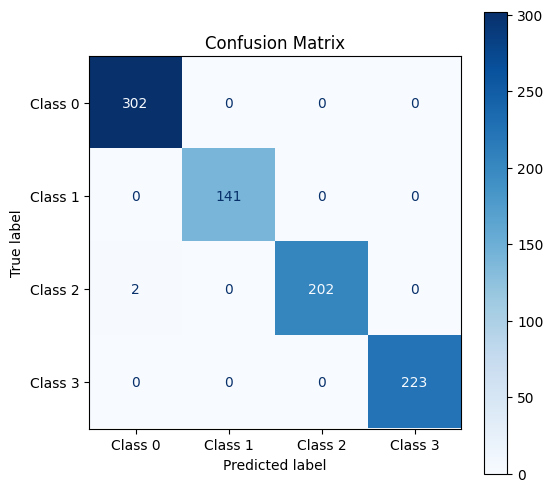

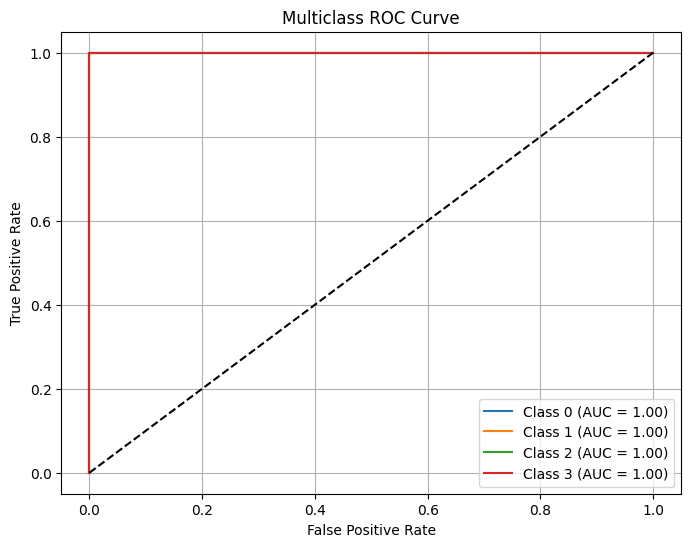

In [15]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import label_binarize

# Load trained model
model.load_state_dict(torch.load('ResNet18_Weights_cauliflower.pth'))
model.eval()

# Evaluation
correct_test = 0
total_test = 0
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# === Classification Metrics ===
test_acc = 100 * correct_test / total_test
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Test Accuracy: {test_acc:.2f}%')
print(f'Precision:     {precision:.4f}')
print(f'Recall:        {recall:.4f}')
print(f'F1 Score:      {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

# === Plot Confusion Matrix ===
# Use your actual class names if available (e.g., from test_dataset.classes)
num_classes = all_probs.shape[1]
class_names = [f'Class {i}' for i in range(num_classes)]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

# === Plot ROC Curve (Multiclass One-vs-Rest) ===
binary_labels = label_binarize(all_labels, classes=list(range(num_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [19]:
from torchvision import datasets

test_dataset = datasets.ImageFolder(
    r"D:\Image analysis folder\Cauliflower\Test",
    transform=test_transform
)

class_names = test_dataset.classes

# Print the actual label names and their corresponding indices
for i, name in enumerate(class_names):
    print(f"Class {i} → {name}")


Class 0 → Alternaria
Class 1 → Healthy
Class 2 → Phosphorous Deficiency
Class 3 → Phytoxicity


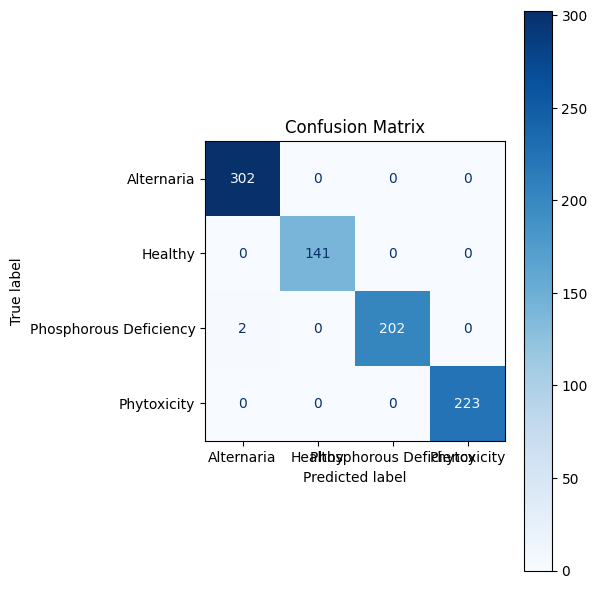

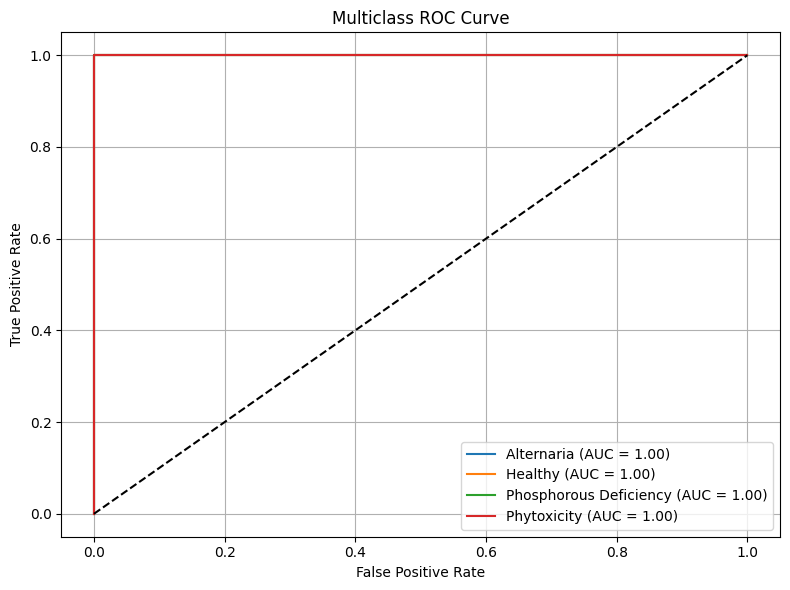

In [22]:
# Confusion Matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.savefig("Confusion matrix resnetweight_cauliflower.jpg", dpi = 600)
plt.tight_layout()
plt.show()


# ROC curve plot (multiclass)
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.savefig("ROC resnet-18 cauliflowwer.jpg", dpi = 600)
plt.grid()
plt.tight_layout()
plt.show()


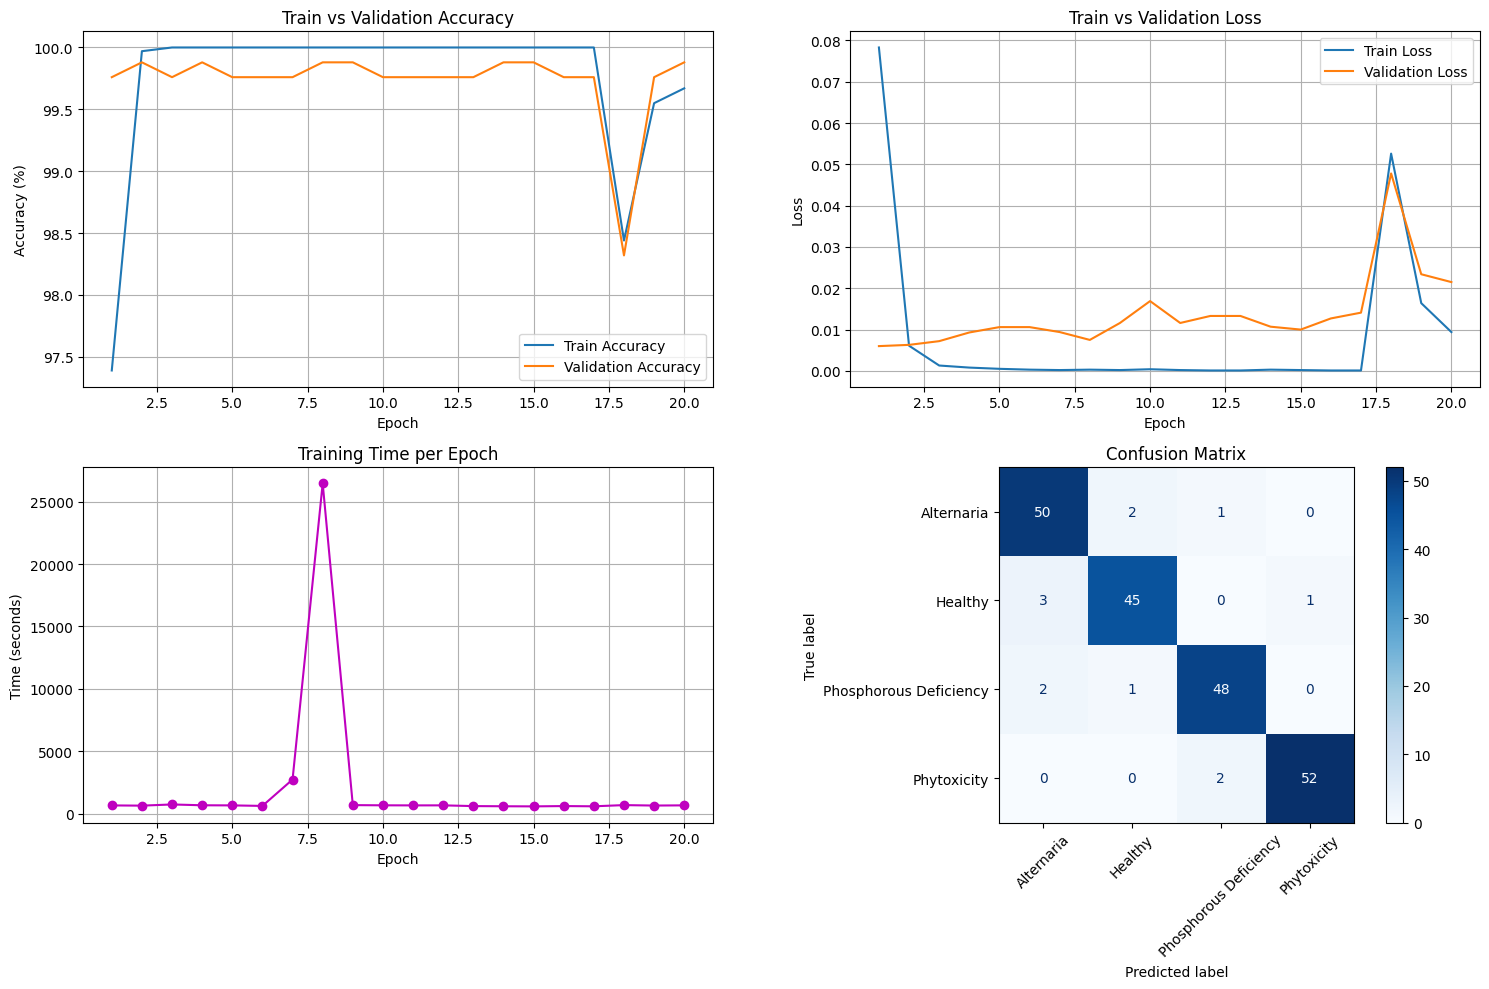

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.gridspec as gridspec

# Your data
epochs = np.arange(1, 21)

train_acc = [97.39, 99.97, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00,
             100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 98.44, 99.55, 99.67]

val_acc = [99.76, 99.88, 99.76, 99.88, 99.76, 99.76, 99.76, 99.88, 99.88, 99.76,
           99.76, 99.76, 99.76, 99.88, 99.88, 99.76, 99.76, 98.32, 99.76, 99.88]

train_loss = [0.0783, 0.0061, 0.0013, 0.0008, 0.0005, 0.0003, 0.0002, 0.0003, 0.0002, 0.0004,
              0.0002, 0.0001, 0.0001, 0.0003, 0.0002, 0.0001, 0.0001, 0.0526, 0.0164, 0.0094]

val_loss = [0.0060, 0.0063, 0.0072, 0.0093, 0.0106, 0.0106, 0.0094, 0.0075, 0.0116, 0.0169,
            0.0116, 0.0133, 0.0133, 0.0107, 0.0100, 0.0127, 0.0141, 0.0478, 0.0234, 0.0215]

time_sec = [672.18, 654.24, 748.60, 683.24, 674.17, 631.68, 2744.77, 26460.17, 695.99, 680.37,
            673.95, 677.15, 617.93, 604.56, 594.81, 620.06, 601.14, 696.69, 661.23, 676.76]

class_names = ['Alternaria', 'Healthy', 'Phosphorous Deficiency', 'Phytoxicity']

conf_matrix = np.array([[50, 2, 1, 0],
                        [3, 45, 0, 1],
                        [2, 1, 48, 0],
                        [0, 0, 2, 52]])

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Train & Validation Accuracy
axs[0, 0].plot(epochs, train_acc, label='Train Accuracy')
axs[0, 0].plot(epochs, val_acc, label='Validation Accuracy')
axs[0, 0].set_title('Train vs Validation Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy (%)')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Train & Validation Loss
axs[0, 1].plot(epochs, train_loss, label='Train Loss')
axs[0, 1].plot(epochs, val_loss, label='Validation Loss')
axs[0, 1].set_title('Train vs Validation Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Training Time per Epoch
axs[1, 0].plot(epochs, time_sec, 'm-o')
axs[1, 0].set_title('Training Time per Epoch')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Time (seconds)')
axs[1, 0].grid(True)

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(ax=axs[1, 1], cmap='Blues', values_format='d')
axs[1, 1].set_title('Confusion Matrix')

# Rotate x-axis labels of confusion matrix by 45 degrees
for tick in axs[1, 1].get_xticklabels():
    tick.set_rotation(45)
plt.savefig("Validation_loss_epoch_matrix.jpg", dpi= 600)  
plt.tight_layout()
plt.show()


In [ ]:
###Used of second model

In [30]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import os

In [34]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
from torchvision import datasets
Crop_name = r"D:\Image analysis folder\Cauliflower"
train_dataset = datasets.ImageFolder(r"D:\Image analysis folder\Cauliflower\Train", transform=train_transform)
test_dataset = datasets.ImageFolder(r"D:\Image analysis folder\Cauliflower\Test", transform=test_transform)


In [37]:
# Dataset directory
Crop_name = r"D:\Image analysis folder\Cauliflower"
train_dir = rf"{Crop_name}\Train"
test_dir = rf"{Crop_name}\Test"

# Create ImageFolder datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

# Get class names
class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['Alternaria', 'Healthy', 'Phosphorous Deficiency', 'Phytoxicity']


In [38]:
model = models.mobilenet_v2(pretrained=True)

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
for param in model.features.parameters():
    param.requires_grad = False

In [40]:
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In [42]:
import time

num_epochs = 20

for epoch in range(num_epochs):
    start_time = time.time()

    # ---------- Training ----------
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects.double() / len(train_dataset)

    # ---------- Evaluation ----------
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    eval_loss = test_loss / len(test_dataset)
    eval_acc = test_corrects.double() / len(test_dataset)

    # ---------- Time ----------
    epoch_time = time.time() - start_time

    # ---------- Summary ----------
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"🟢 Train     - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"🔵 Eval/Test - Loss: {eval_loss:.4f}, Accuracy: {eval_acc:.4f}")
    print(f"⏱️  Time Taken: {epoch_time:.2f} sec")



Epoch 1/20
🟢 Train     - Loss: 0.7919, Accuracy: 0.7961
🔵 Eval/Test - Loss: 0.4147, Accuracy: 0.9678
⏱️  Time Taken: 294.93 sec

Epoch 2/20
🟢 Train     - Loss: 0.3872, Accuracy: 0.9394
🔵 Eval/Test - Loss: 0.2360, Accuracy: 0.9724
⏱️  Time Taken: 235.96 sec

Epoch 3/20
🟢 Train     - Loss: 0.2626, Accuracy: 0.9566
🔵 Eval/Test - Loss: 0.1684, Accuracy: 0.9747
⏱️  Time Taken: 238.43 sec

Epoch 4/20
🟢 Train     - Loss: 0.2077, Accuracy: 0.9595
🔵 Eval/Test - Loss: 0.1417, Accuracy: 0.9724
⏱️  Time Taken: 248.96 sec

Epoch 5/20
🟢 Train     - Loss: 0.1745, Accuracy: 0.9612
🔵 Eval/Test - Loss: 0.1167, Accuracy: 0.9759
⏱️  Time Taken: 235.02 sec

Epoch 6/20
🟢 Train     - Loss: 0.1482, Accuracy: 0.9657
🔵 Eval/Test - Loss: 0.1050, Accuracy: 0.9759
⏱️  Time Taken: 231.52 sec

Epoch 7/20
🟢 Train     - Loss: 0.1359, Accuracy: 0.9686
🔵 Eval/Test - Loss: 0.0942, Accuracy: 0.9747
⏱️  Time Taken: 233.22 sec

Epoch 8/20
🟢 Train     - Loss: 0.1228, Accuracy: 0.9710
🔵 Eval/Test - Loss: 0.0901, Accuracy: 0.

In [43]:
torch.save(model.state_dict(), 'Mobilenetv2_cauliflower.pth')

Test Accuracy: 99.20%
Precision:     0.9920
Recall:        0.9920
F1 Score:      0.9920
Confusion Matrix:
[[301   0   1   0]
 [  0 138   1   2]
 [  0   3 201   0]
 [  0   0   0 223]]


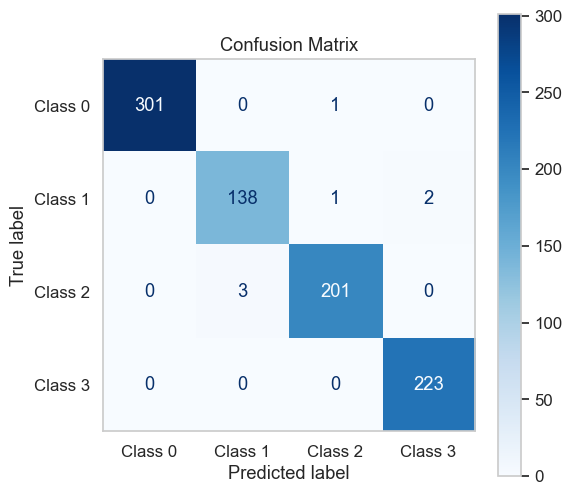

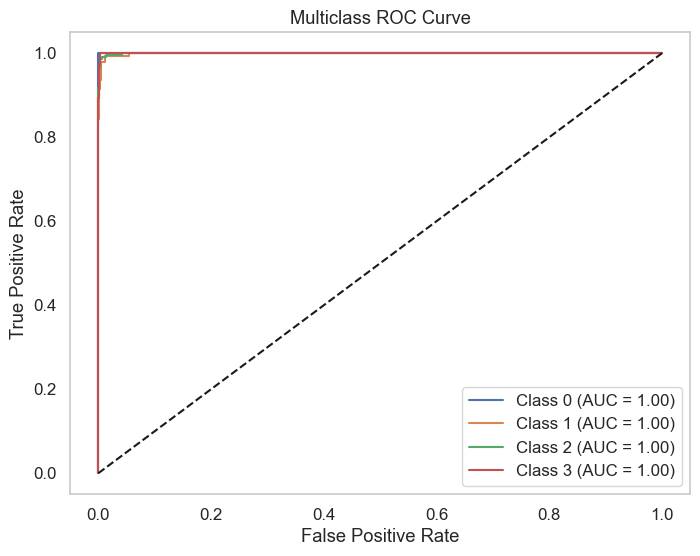

In [54]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import label_binarize

# Load trained model
model.load_state_dict(torch.load('Mobilenetv2_cauliflower.pth'))
model.eval()

# Evaluation
correct_test = 0
total_test = 0
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# === Classification Metrics ===
test_acc = 100 * correct_test / total_test
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Test Accuracy: {test_acc:.2f}%')
print(f'Precision:     {precision:.4f}')
print(f'Recall:        {recall:.4f}')
print(f'F1 Score:      {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

# === Plot Confusion Matrix ===
# Use your actual class names if available (e.g., from test_dataset.classes)
num_classes = all_probs.shape[1]
class_names = [f'Class {i}' for i in range(num_classes)]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

# === Plot ROC Curve (Multiclass One-vs-Rest) ===
binary_labels = label_binarize(all_labels, classes=list(range(num_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Class 0 → Alternaria
Class 1 → Healthy
Class 2 → Phosphorous Deficiency
Class 3 → Phytoxicity


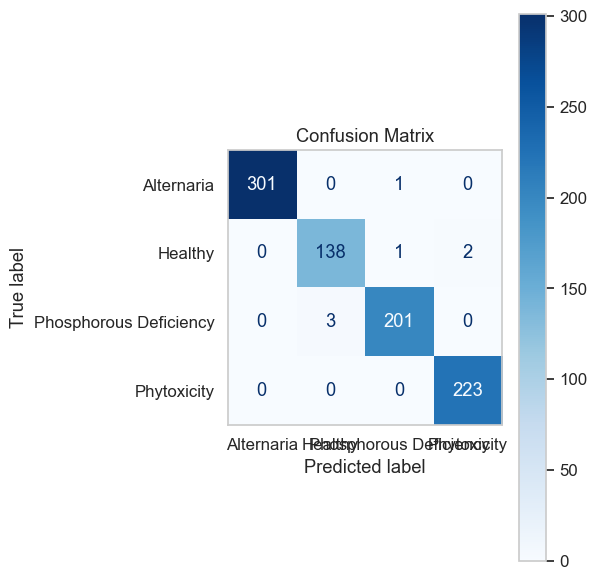

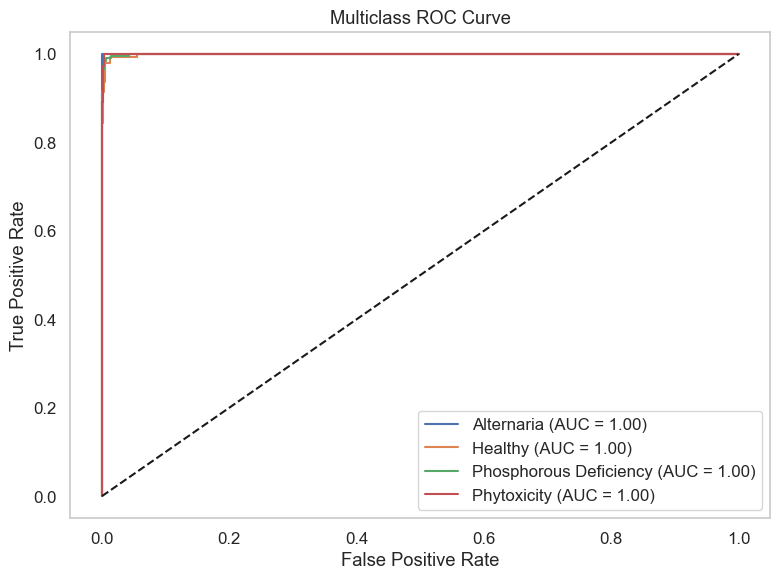

In [60]:
from torchvision import datasets

test_dataset = datasets.ImageFolder(
    r"D:\Image analysis folder\Cauliflower\Test",
    transform=test_transform
)

class_names = test_dataset.classes

# Print the actual label names and their corresponding indices
for i, name in enumerate(class_names):
    print(f"Class {i} → {name}")

# Confusion Matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.savefig("Confusion matrix mobilenet_cauliflower.jpg", dpi = 600)
plt.tight_layout()
plt.show()


# ROC curve plot (multiclass)
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.savefig("ROC mobile net.jpg", dpi = 600)
plt.grid()
plt.tight_layout()
plt.show()

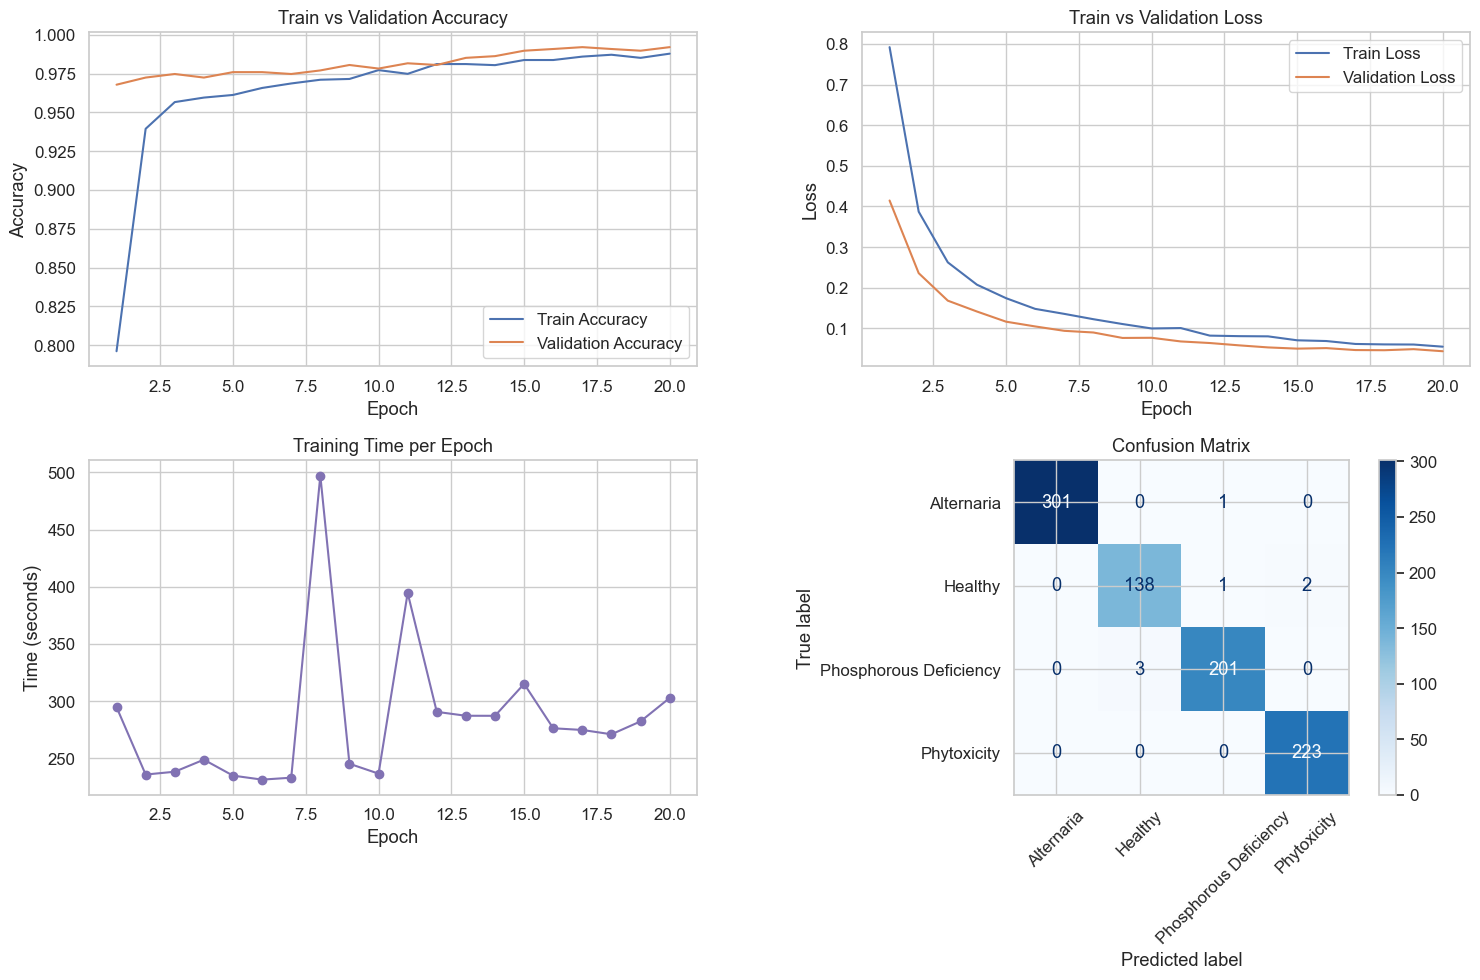

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Epochs
epochs = np.arange(1, 21)

# Data
train_losses = [0.7919, 0.3872, 0.2626, 0.2077, 0.1745, 0.1482, 0.1359, 0.1228, 0.1109, 0.1000,
                0.1010, 0.0824, 0.0811, 0.0806, 0.0709, 0.0691, 0.0619, 0.0608, 0.0605, 0.0552]
test_losses = [0.4147, 0.2360, 0.1684, 0.1417, 0.1167, 0.1050, 0.0942, 0.0901, 0.0767, 0.0771,
               0.0681, 0.0642, 0.0585, 0.0534, 0.0504, 0.0517, 0.0469, 0.0465, 0.0491, 0.0440]
train_accuracies = [0.7961, 0.9394, 0.9566, 0.9595, 0.9612, 0.9657, 0.9686, 0.9710, 0.9715, 0.9772,
                    0.9748, 0.9811, 0.9811, 0.9804, 0.9837, 0.9837, 0.9859, 0.9871, 0.9851, 0.9878]
test_accuracies = [0.9678, 0.9724, 0.9747, 0.9724, 0.9759, 0.9759, 0.9747, 0.9770, 0.9805, 0.9782,
                   0.9816, 0.9805, 0.9851, 0.9862, 0.9897, 0.9908, 0.9920, 0.9908, 0.9897, 0.9920]
times = [294.93, 235.96, 238.43, 248.96, 235.02, 231.52, 233.22, 497.33, 245.40, 236.76,
         394.65, 290.76, 287.35, 287.31, 315.23, 276.41, 274.93, 271.15, 282.45, 302.91]

class_names = ['Alternaria', 'Healthy', 'Phosphorous Deficiency', 'Phytoxicity']
conf_matrix = np.array([[301, 0, 1, 0],
                        [0, 138, 1, 2],
                        [0, 3, 201, 0],
                        [0, 0, 0, 223]])

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Train vs Validation Accuracy
axs[0, 0].plot(epochs, train_accuracies, label='Train Accuracy')
axs[0, 0].plot(epochs, test_accuracies, label='Validation Accuracy')
axs[0, 0].set_title('Train vs Validation Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Train vs Validation Loss
axs[0, 1].plot(epochs, train_losses, label='Train Loss')
axs[0, 1].plot(epochs, test_losses, label='Validation Loss')
axs[0, 1].set_title('Train vs Validation Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Training Time per Epoch
axs[1, 0].plot(epochs, times, 'm-o')
axs[1, 0].set_title('Training Time per Epoch')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Time (seconds)')
axs[1, 0].grid(True)

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(ax=axs[1, 1], cmap='Blues', values_format='d')
axs[1, 1].set_title('Confusion Matrix')

# Rotate x-ticks of confusion matrix
for tick in axs[1, 1].get_xticklabels():
    tick.set_rotation(45)

plt.tight_layout()
plt.savefig("Validation_loss_epoch_matrix mobile net v2.jpg", dpi=600)
plt.show()


In [ ]:
##To develop the saliency map 

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


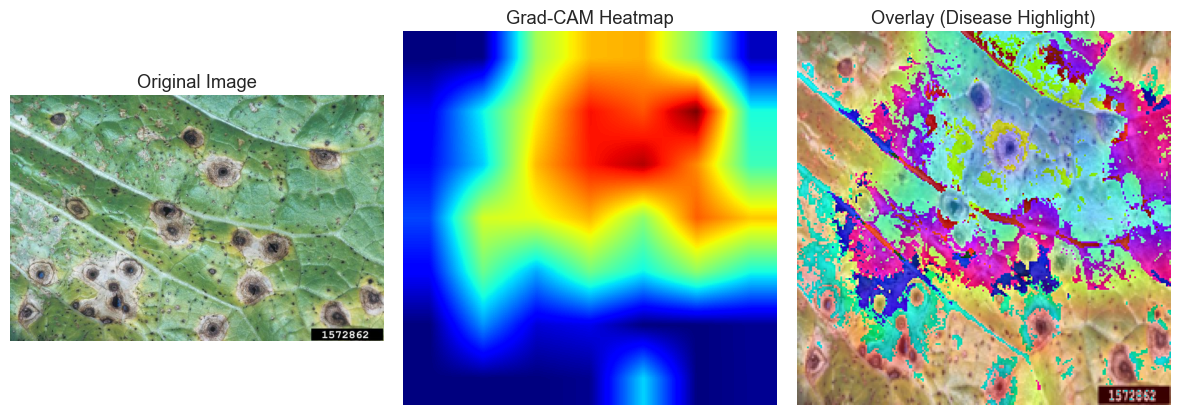

In [70]:
import os
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ====== Load Trained Model ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.last_channel, 4)
model.load_state_dict(torch.load("Mobilenetv2_cauliflower.pth", map_location=device))
model.to(device)
model.eval()

# ====== Transform ======
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ====== Hook containers ======
features = []
gradients = []

def forward_hook(module, input, output):
    features.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register hooks on the last conv layer
target_layer = model.features[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

# ====== Load and preprocess image ======
image_dir = r"D:\Image analysis folder\Cauliflower\Train\Alternaria"
valid_exts = ('.jpg', '.jpeg', '.png', '.bmp')
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(valid_exts)]
if not image_files:
    raise FileNotFoundError("No image files found in the specified directory.")

image_name = image_files[0]
img_path = os.path.join(image_dir, image_name)

img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# ====== Forward and Backward Pass ======
output = model(input_tensor)
pred_class = output.argmax(dim=1)
model.zero_grad()
output[0, pred_class].backward()

# ====== Grad-CAM calculation ======
feature_map = features[0].squeeze(0)           # [C, H, W]
gradient_map = gradients[0].squeeze(0)          # [C, H, W]

weights = torch.mean(gradient_map, dim=(1, 2))  # Global average pooling

gradcam = torch.zeros(feature_map.shape[1:], dtype=torch.float32).to(device)
for i, w in enumerate(weights):
    gradcam += w * feature_map[i]

# Apply ReLU
gradcam = F.relu(gradcam)
gradcam = gradcam.cpu().detach().numpy()
gradcam = cv2.resize(gradcam, (224, 224))
gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())

# ====== Overlay Heatmap ======
img_np = np.array(img.resize((224, 224)))
heatmap_color = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
overlay = heatmap_color * 0.4 + img_np

# ====== Plot ======
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gradcam, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(np.uint8(overlay))
plt.title("Overlay (Disease Highlight)")
plt.axis("off")

plt.tight_layout()
#plt.savefig("Mobilenet v2_heatmap saliency.jpg",dpi = 600)
plt.show()


C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


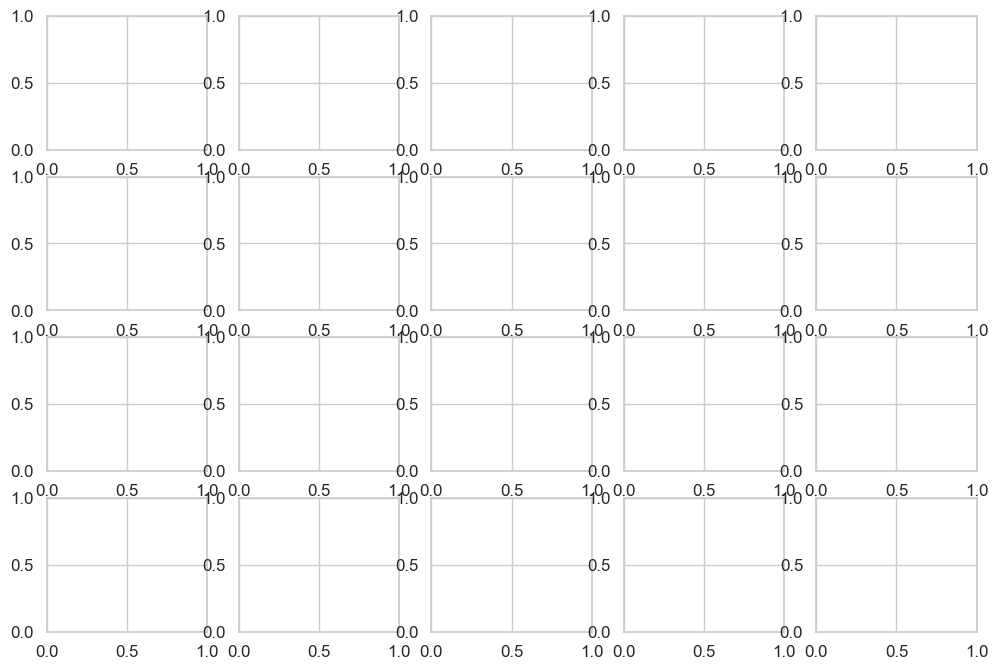

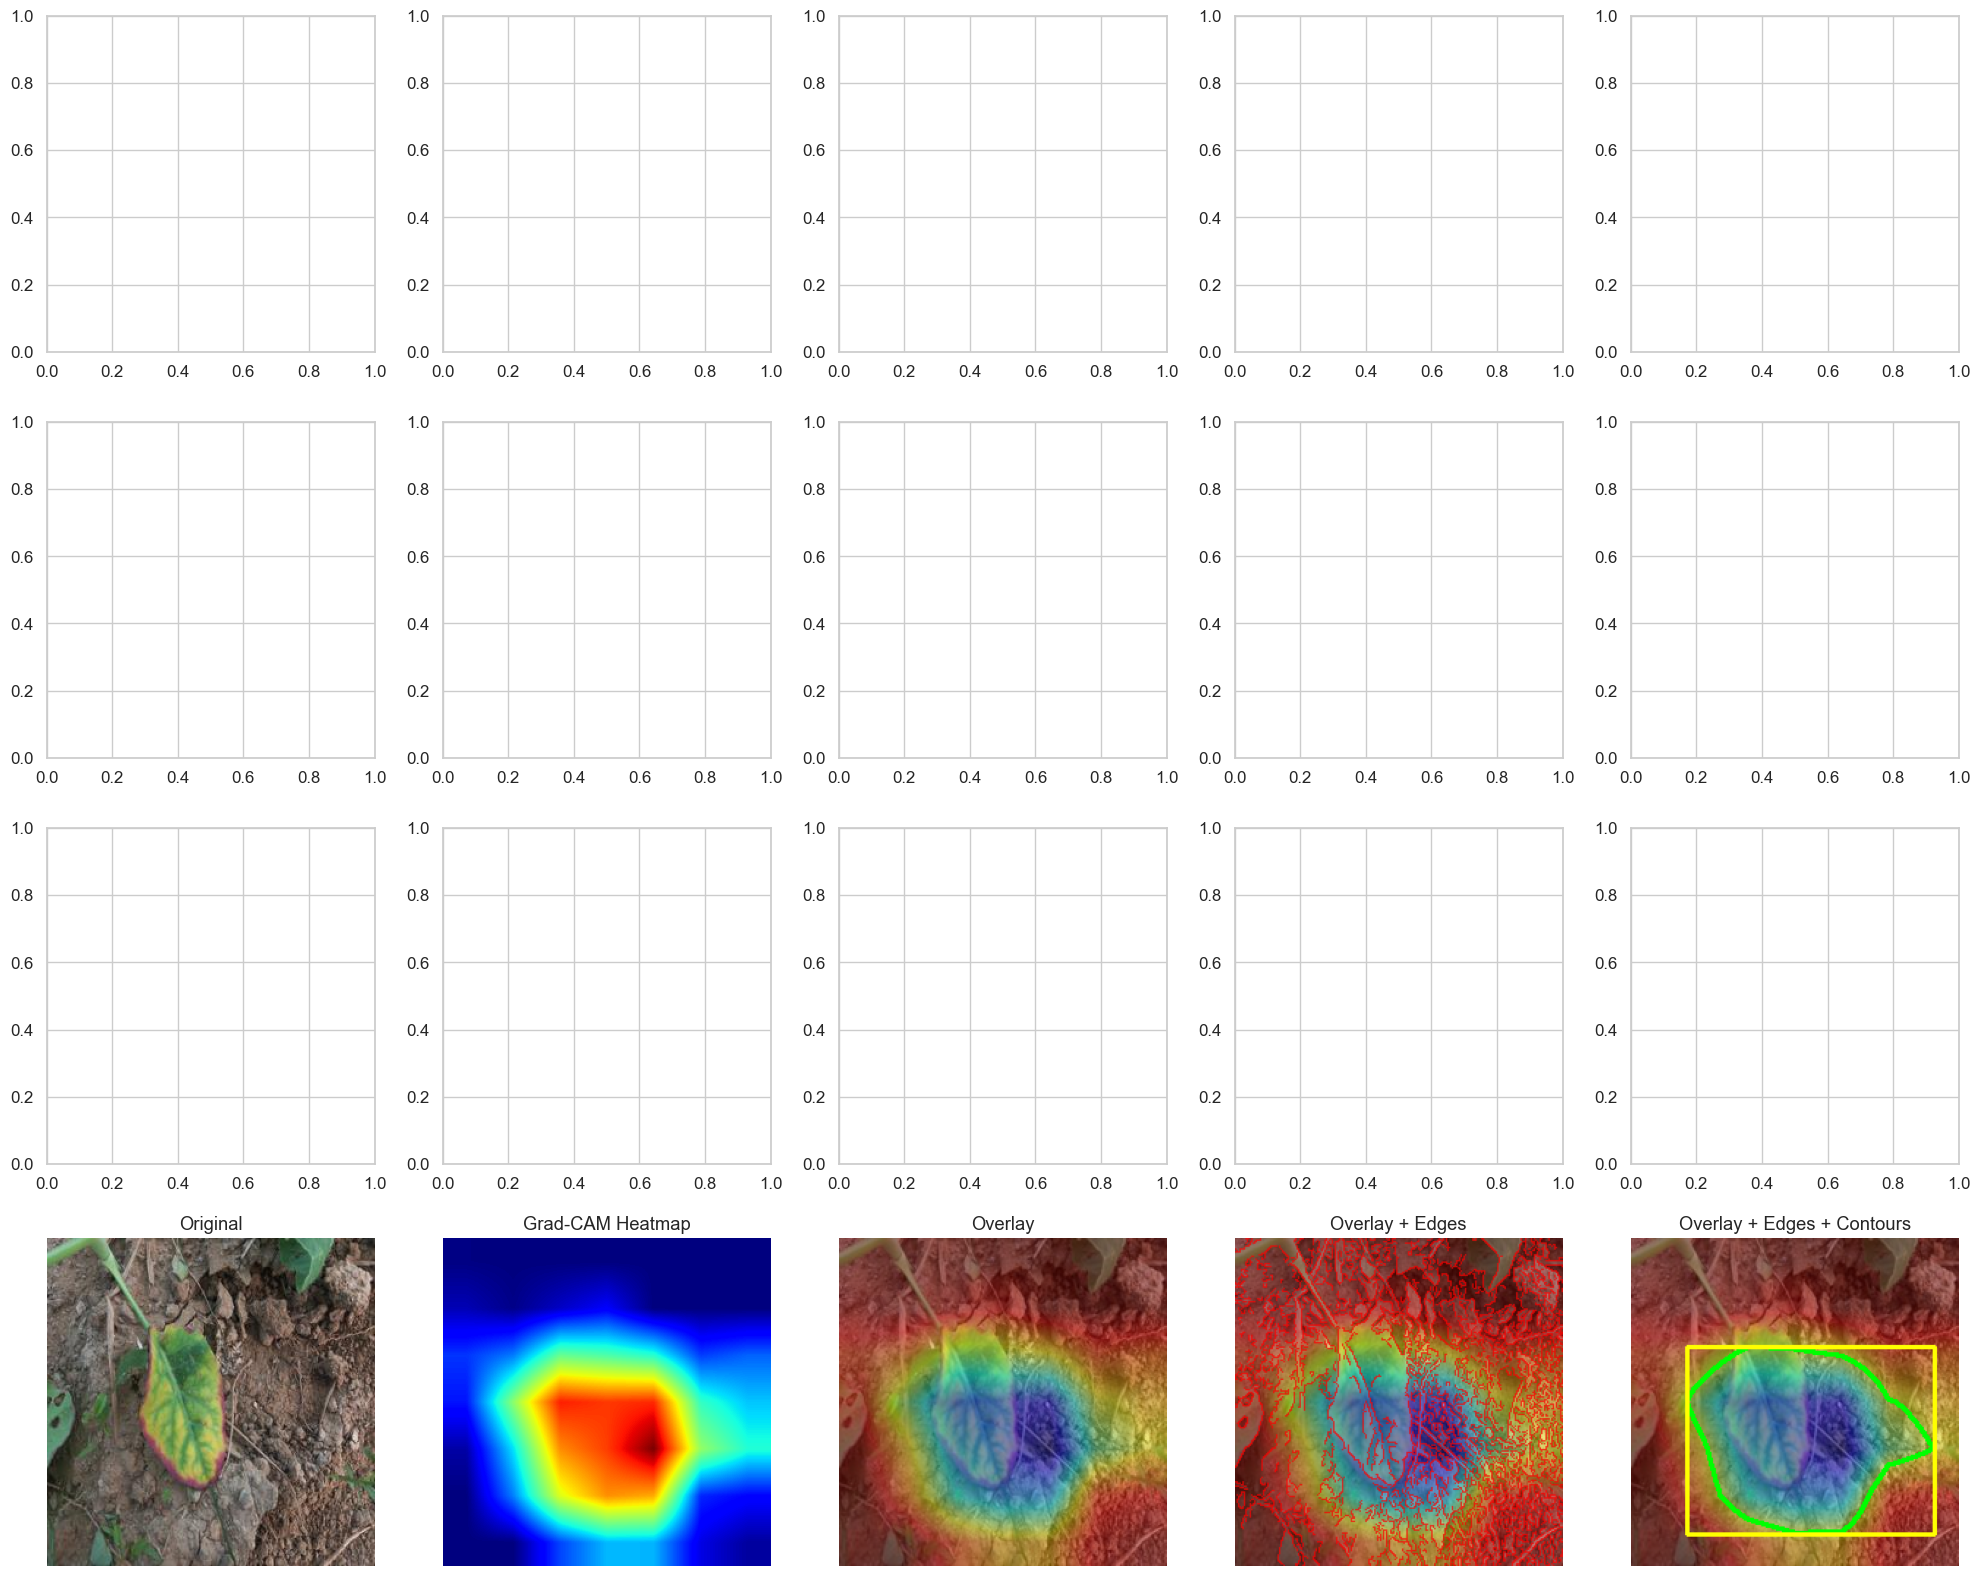

In [83]:
import os
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ====== Load Trained Model ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.last_channel, 4)  # Adjust num classes as needed
model.load_state_dict(torch.load("Mobilenetv2_cauliflower.pth", map_location=device))
model.to(device)
model.eval()

# ====== Transform ======
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ====== Hook containers ======
features = []
gradients = []

def forward_hook(module, input, output):
    features.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register hooks on the last conv layer
target_layer = model.features[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

def gradcam_and_overlay(img, input_tensor, model, device):
    features.clear()
    gradients.clear()
    
    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax(dim=1)
    
    model.zero_grad()
    output[0, pred_class].backward()
    
    # Get feature and gradient maps
    feature_map = features[0].squeeze(0)   # [C, H, W]
    gradient_map = gradients[0].squeeze(0) # [C, H, W]
    
    # Global average pooling of gradients
    weights = torch.mean(gradient_map, dim=(1, 2))
    
    # Weighted sum of feature maps
    gradcam = torch.zeros(feature_map.shape[1:], dtype=torch.float32).to(device)
    for i, w in enumerate(weights):
        gradcam += w * feature_map[i]
        
    gradcam = F.relu(gradcam)
    gradcam = gradcam.cpu().detach().numpy()
    gradcam = cv2.resize(gradcam, (224, 224))
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min() + 1e-8)  # normalize
    
    # Prepare overlay
    img_np = np.array(img.resize((224, 224)))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap_color, 0.4, img_np, 0.6, 0)
    
    # Edge detection on grayscale resized image
    gray_img = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_img, threshold1=100, threshold2=200)
    
    # Red edges overlay
    edges_rgb = np.zeros_like(img_np)
    edges_rgb[edges != 0] = [255, 0, 0]
    
    # Combine edges with overlay
    alpha = 0.7
    mask = edges != 0
    overlay_with_edges = overlay.copy()
    overlay_with_edges[mask] = (
        alpha * edges_rgb[mask] + (1 - alpha) * overlay_with_edges[mask]
    ).astype(np.uint8)
    
    return gradcam, overlay, overlay_with_edges, img_np

# ==== Multi-class comparison ====

categories = [
    r"D:\Image analysis folder\Cauliflower\Train\Healthy",
    r"D:\Image analysis folder\Cauliflower\Train\Alternaria",
    r"D:\Image analysis folder\Cauliflower\Train\Phytoxicity",
    r"D:\Image analysis folder\Cauliflower\Train\Phosphorous Deficiency"
]

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp')
fig, axes = plt.subplots(len(categories), 5, figsize=(20, 16))
fig.set_size_inches(12, 8)
fig, axes = plt.subplots(len(categories), 5, figsize=(20, 16))
plot_titles = ["Original", "Grad-CAM Heatmap", "Overlay", "Overlay + Edges", "Overlay + Edges + Contours"]

for row, category_dir in enumerate(categories):
    image_files = [f for f in os.listdir(category_dir) if f.lower().endswith(valid_exts)]
    if not image_files:
        print(f"No images found in {category_dir}")
        continue
    img_path = os.path.join(category_dir, image_files[0])
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)
    
    gradcam, overlay, overlay_with_edges, img_np = gradcam_and_overlay(img, input_tensor, model, device)
    
   # Threshold Grad-CAM heatmap for contours
_, thresh = cv2.threshold(np.uint8(255 * gradcam), 100, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

overlay_with_contours = overlay.copy()

# Draw contours and bounding boxes
for cnt in contours:
    # Draw contour in green
    cv2.drawContours(overlay_with_contours, [cnt], -1, (0, 255, 0), 2)
    
    # Get and draw bounding box in yellow
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(overlay_with_contours, (x, y), (x + w, y + h), (255, 255, 0), 2)

    
    # Plot all 5 images in the row
    axes[row, 0].imshow(img)
    axes[row, 0].set_title(plot_titles[0])
    axes[row, 0].axis('off')
    
    axes[row, 1].imshow(gradcam, cmap='jet')
    axes[row, 1].set_title(plot_titles[1])
    axes[row, 1].axis('off')
    
    axes[row, 2].imshow(overlay)
    axes[row, 2].set_title(plot_titles[2])
    axes[row, 2].axis('off')
    
    axes[row, 3].imshow(overlay_with_edges)
    axes[row, 3].set_title(plot_titles[3])
    axes[row, 3].axis('off')
    
    axes[row, 4].imshow(overlay_with_contours)
    axes[row, 4].set_title(plot_titles[4])
    axes[row, 4].axis('off')
#plt.savefig("Saliency map of mobilenetv2_allcat.jpg", dpi =600)
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


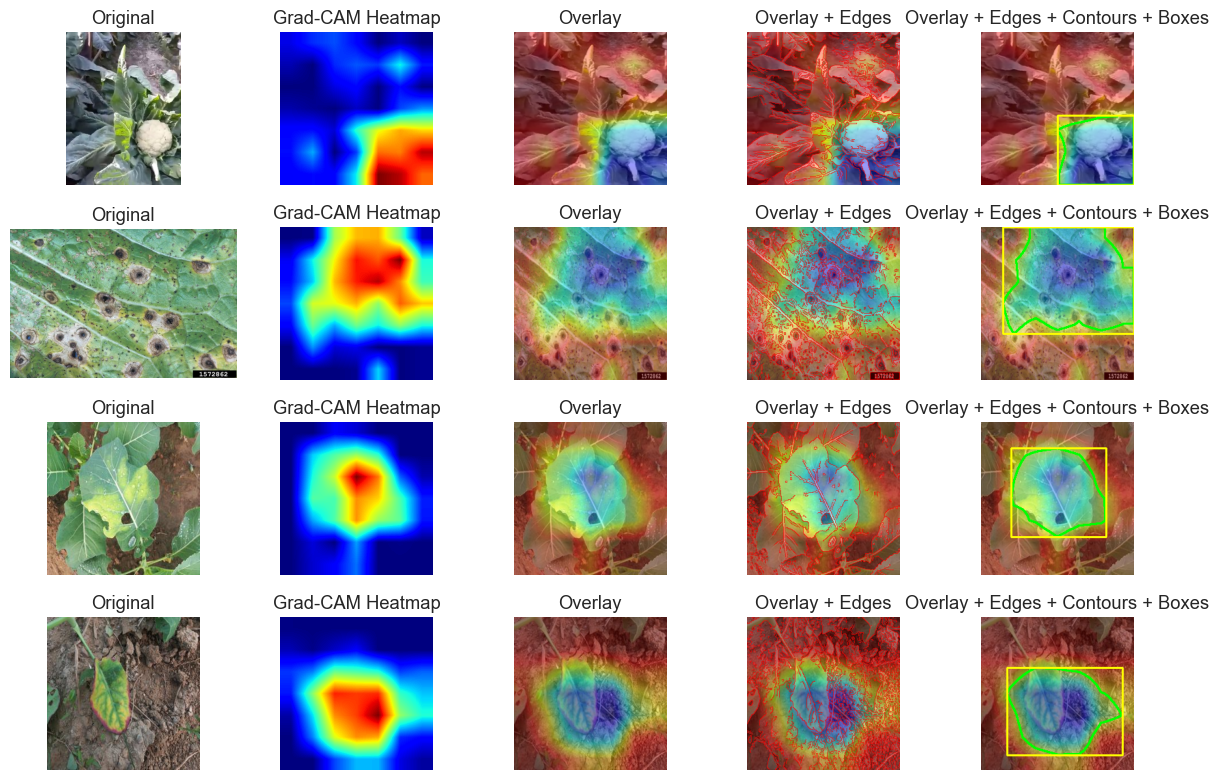

In [84]:
import os
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ====== Load Trained Model ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.last_channel, 4)  # Adjust num classes as needed
model.load_state_dict(torch.load("Mobilenetv2_cauliflower.pth", map_location=device))
model.to(device)
model.eval()

# ====== Transform ======
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ====== Hook containers ======
features = []
gradients = []

def forward_hook(module, input, output):
    features.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register hooks on the last conv layer
target_layer = model.features[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

def gradcam_and_overlay(img, input_tensor, model, device):
    features.clear()
    gradients.clear()

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax(dim=1)

    model.zero_grad()
    output[0, pred_class].backward()

    # Get feature and gradient maps
    feature_map = features[0].squeeze(0)   # [C, H, W]
    gradient_map = gradients[0].squeeze(0) # [C, H, W]

    # Global average pooling of gradients
    weights = torch.mean(gradient_map, dim=(1, 2))

    # Weighted sum of feature maps
    gradcam = torch.zeros(feature_map.shape[1:], dtype=torch.float32).to(device)
    for i, w in enumerate(weights):
        gradcam += w * feature_map[i]

    gradcam = F.relu(gradcam)
    gradcam = gradcam.cpu().detach().numpy()
    gradcam = cv2.resize(gradcam, (224, 224))
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min() + 1e-8)  # normalize

    # Prepare overlay
    img_np = np.array(img.resize((224, 224)))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap_color, 0.4, img_np, 0.6, 0)

    # Edge detection on grayscale resized image
    gray_img = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_img, threshold1=100, threshold2=200)

    # Red edges overlay
    edges_rgb = np.zeros_like(img_np)
    edges_rgb[edges != 0] = [255, 0, 0]

    # Combine edges with overlay
    alpha = 0.7
    mask = edges != 0
    overlay_with_edges = overlay.copy()
    overlay_with_edges[mask] = (
        alpha * edges_rgb[mask] + (1 - alpha) * overlay_with_edges[mask]
    ).astype(np.uint8)

    return gradcam, overlay, overlay_with_edges, img_np

# ==== Multi-class comparison ====

categories = [
    r"D:\\Image analysis folder\\Cauliflower\\Train\\Healthy",
    r"D:\\Image analysis folder\\Cauliflower\\Train\\Alternaria",
    r"D:\\Image analysis folder\\Cauliflower\\Train\\Phytoxicity",
    r"D:\\Image analysis folder\\Cauliflower\\Train\\Phosphorous Deficiency"
]

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp')
fig, axes = plt.subplots(len(categories), 5, figsize=(20, 16))
fig.set_size_inches(12, 8)
plot_titles = ["Original", "Grad-CAM Heatmap", "Overlay", "Overlay + Edges", "Overlay + Edges + Contours + Boxes"]

for row, category_dir in enumerate(categories):
    image_files = [f for f in os.listdir(category_dir) if f.lower().endswith(valid_exts)]
    if not image_files:
        print(f"No images found in {category_dir}")
        continue
    img_path = os.path.join(category_dir, image_files[0])
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    gradcam, overlay, overlay_with_edges, img_np = gradcam_and_overlay(img, input_tensor, model, device)

    # Threshold Grad-CAM heatmap for contours and boxes
    _, thresh = cv2.threshold(np.uint8(255 * gradcam), 100, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    overlay_with_contours = overlay.copy()
    for cnt in contours:
        cv2.drawContours(overlay_with_contours, [cnt], -1, (0, 255, 0), 2)  # green contours
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(overlay_with_contours, (x, y), (x + w, y + h), (255, 255, 0), 2)  # yellow boxes

    # Plot all 5 images in the row
    axes[row, 0].imshow(img)
    axes[row, 0].set_title(plot_titles[0])
    axes[row, 0].axis('off')

    axes[row, 1].imshow(gradcam, cmap='jet')
    axes[row, 1].set_title(plot_titles[1])
    axes[row, 1].axis('off')

    axes[row, 2].imshow(overlay)
    axes[row, 2].set_title(plot_titles[2])
    axes[row, 2].axis('off')

    axes[row, 3].imshow(overlay_with_edges)
    axes[row, 3].set_title(plot_titles[3])
    axes[row, 3].axis('off')

    axes[row, 4].imshow(overlay_with_contours)
    axes[row, 4].set_title(plot_titles[4])
    axes[row, 4].axis('off')

plt.tight_layout()
#plt.savefig("Saliency_map_mobilenetv2_allcat.jpg", dpi=600)
plt.show()


C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


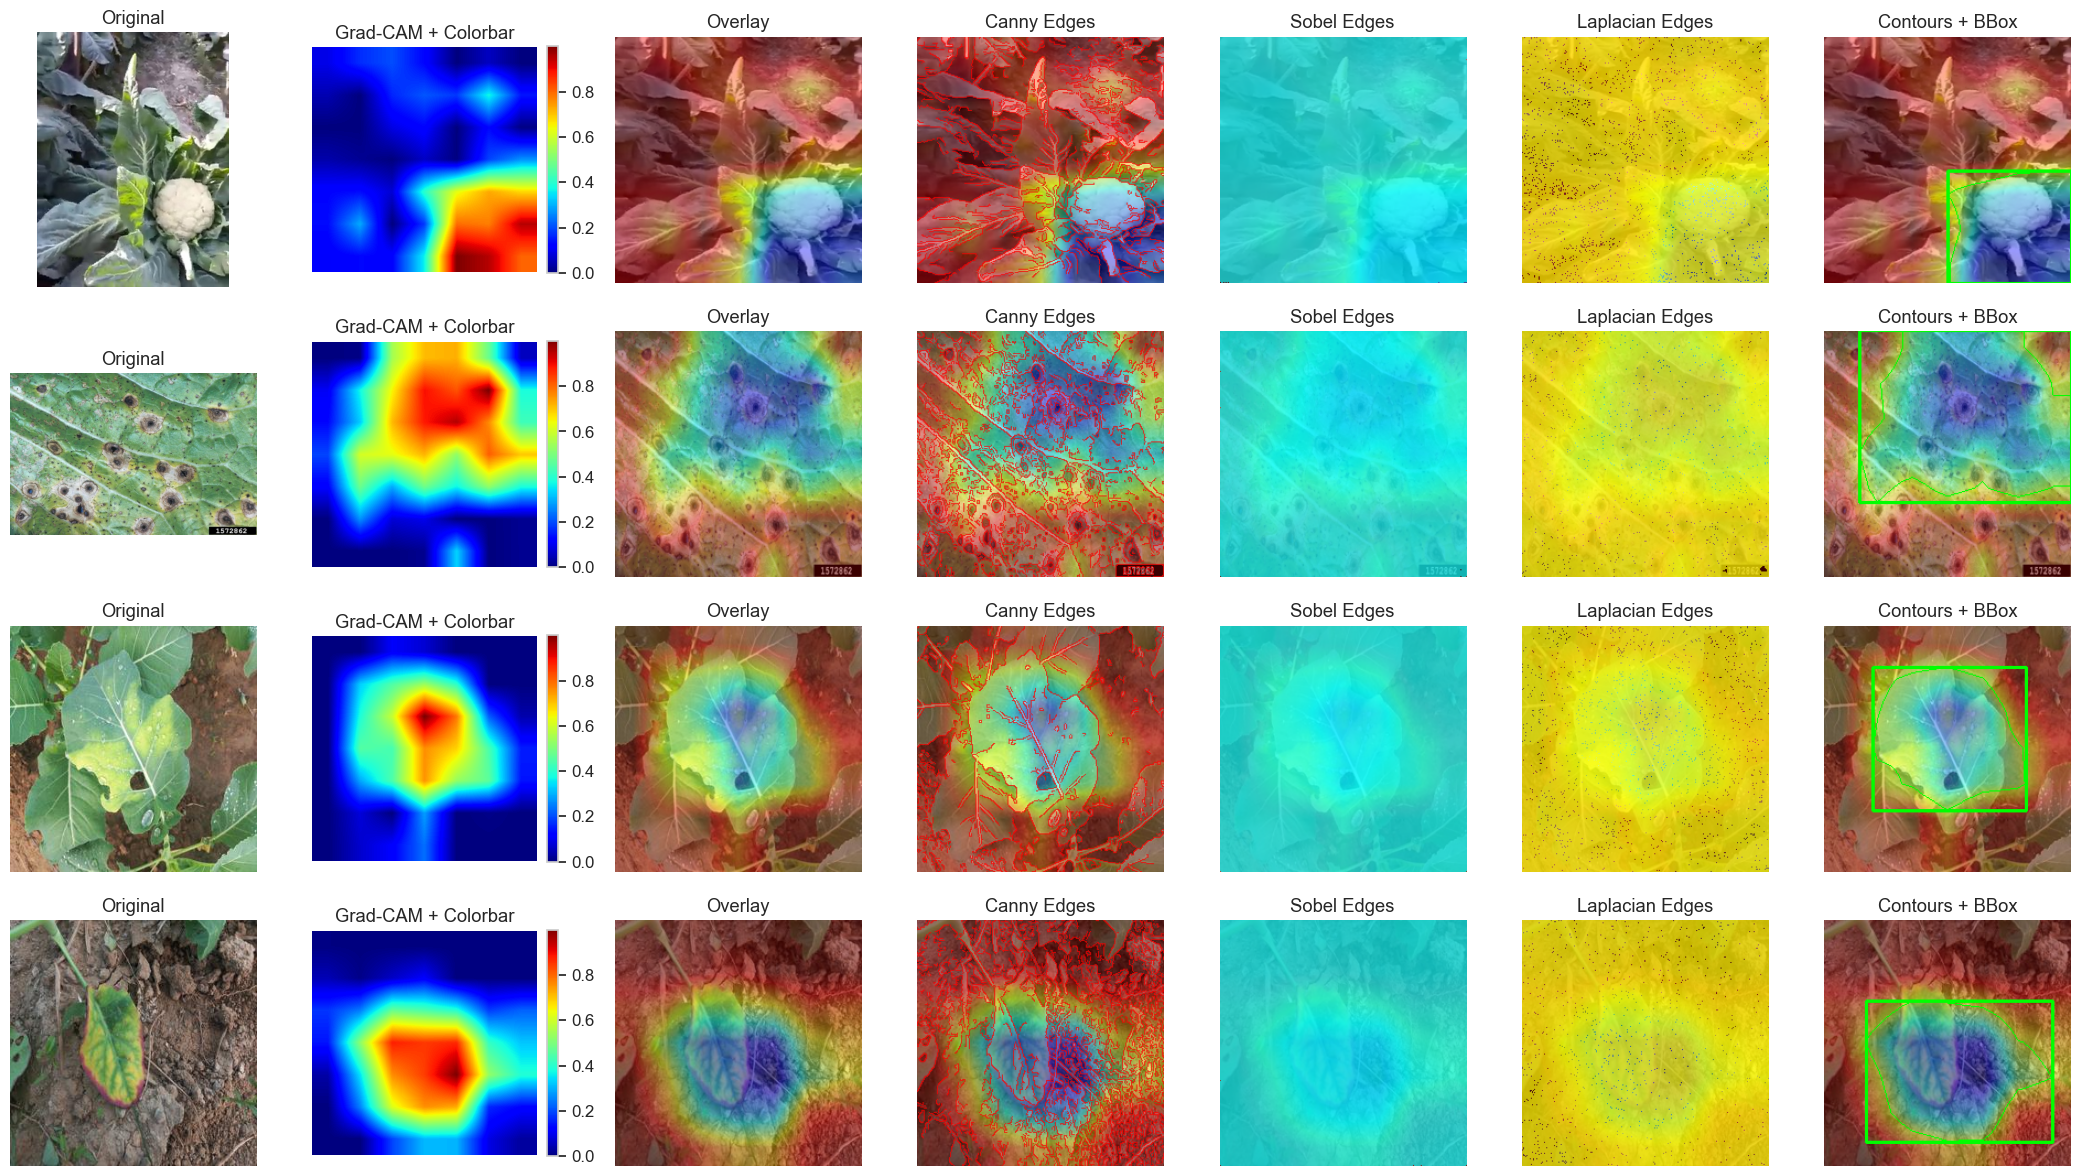

In [87]:
import os
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colorbar as cbar
import cv2

# ====== Load Trained Model ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.last_channel, 4)  # Adjust num classes
model.load_state_dict(torch.load("Mobilenetv2_cauliflower.pth", map_location=device))
model.to(device)
model.eval()

# ====== Transform ======
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ====== Hook containers ======
features = []
gradients = []

def forward_hook(module, input, output):
    features.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

target_layer = model.features[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

def gradcam_and_visuals(img, input_tensor, model, device):
    features.clear()
    gradients.clear()
    
    output = model(input_tensor)
    pred_class = output.argmax(dim=1)
    model.zero_grad()
    output[0, pred_class].backward()
    
    feature_map = features[0].squeeze(0)
    gradient_map = gradients[0].squeeze(0)
    
    weights = torch.mean(gradient_map, dim=(1, 2))
    gradcam = torch.zeros(feature_map.shape[1:], dtype=torch.float32).to(device)
    for i, w in enumerate(weights):
        gradcam += w * feature_map[i]
        
    gradcam = F.relu(gradcam)
    gradcam = gradcam.cpu().detach().numpy()
    gradcam = cv2.resize(gradcam, (224, 224))
    gradcam_norm = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min() + 1e-8)
    
    img_np = np.array(img.resize((224, 224)))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * gradcam_norm), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap_color, 0.4, img_np, 0.6, 0)

    # Edge detection variants
    gray_img = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    canny_edges = cv2.Canny(gray_img, threshold1=100, threshold2=200)
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=5)
    sobel_edges = cv2.convertScaleAbs(np.sqrt(sobel_x**2 + sobel_y**2))
    laplacian_edges = cv2.convertScaleAbs(cv2.Laplacian(gray_img, cv2.CV_64F))

    # Overlay each edge type
    def overlay_edges(base_overlay, edge_img, color):
        edges_rgb = np.zeros_like(img_np)
        edges_rgb[edge_img != 0] = color
        combined = base_overlay.copy()
        mask = edge_img != 0
        combined[mask] = (0.7 * edges_rgb[mask] + 0.3 * combined[mask]).astype(np.uint8)
        return combined

    overlay_canny = overlay_edges(overlay, canny_edges, [255, 0, 0])
    overlay_sobel = overlay_edges(overlay, sobel_edges, [0, 255, 255])
    overlay_laplacian = overlay_edges(overlay, laplacian_edges, [255, 255, 0])

    # Contours + bounding boxes
    _, thresh = cv2.threshold(np.uint8(255 * gradcam_norm), 100, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    overlay_contours = overlay.copy()
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(overlay_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.drawContours(overlay_contours, [c], -1, (0, 255, 0), 1)

    return {
        "original": img,
        "gradcam": gradcam_norm,
        "overlay": overlay,
        "canny": overlay_canny,
        "sobel": overlay_sobel,
        "laplacian": overlay_laplacian,
        "contours": overlay_contours
    }

# ==== Load and visualize ====
categories = [
    r"D:\Image analysis folder\Cauliflower\Train\Healthy",
    r"D:\Image analysis folder\Cauliflower\Train\Alternaria",
    r"D:\Image analysis folder\Cauliflower\Train\Phytoxicity",
    r"D:\Image analysis folder\Cauliflower\Train\Phosphorous Deficiency"
]

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp')
plot_titles = [
    "Original", "Grad-CAM + Colorbar", "Overlay",
    "Canny Edges", "Sobel Edges", "Laplacian Edges", "Contours + BBox"
]

fig, axes = plt.subplots(len(categories), 7, figsize=(21, 12))

for row, category_dir in enumerate(categories):
    image_files = [f for f in os.listdir(category_dir) if f.lower().endswith(valid_exts)]
    if not image_files:
        print(f"No images found in {category_dir}")
        continue

    img_path = os.path.join(category_dir, image_files[0])
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    result = gradcam_and_visuals(img, input_tensor, model, device)

    for col, key in enumerate(result):
        if key == "gradcam":
            im = axes[row, col].imshow(result[key], cmap='jet')
            axes[row, col].set_title(plot_titles[col])
            plt.colorbar(im, ax=axes[row, col], fraction=0.046, pad=0.04)
        elif key == "original":
            axes[row, col].imshow(result[key])
            axes[row, col].set_title(plot_titles[col])
        else:
            axes[row, col].imshow(result[key])
            axes[row, col].set_title(plot_titles[col])
        axes[row, col].axis('off')

plt.tight_layout()
#plt.savefig("Full_GradCAM_Visuals_with_Edges_and_Boxes_mobilenet_v2_cauli.jpg", dpi=300)
plt.savefig("copy_cauli.jpg", dpi=300)
plt.show()